# Wildcat Farm (Scenario 1: worst-case) - flopy

## Model Description 

#### Dimensions: 
- rows = 30
- cols = 25
- layers = 1
- dx = dy = 100 m
- top (flat land surface datum) = z_surf = 100 m
- botm = -150 m
- dz = 250 m  

#### Subsurface Properties: 
- Heterogeneous 
- K = Built an IDW-interpolated K field (hk2d = idw_2d(...)) from four K control points (near corners), then fed that in as hk = hk2d[np.newaxis, :, :].
- NOTE: Below parameters are not used in the steady-state flow run
- Porosity = 0.35 
- Specific yield = 0.3  

#### Boundary Conditions: 
 - Constant-head boundaries are row-varying
 - Set ibound[:,:,0] = -1 and ibound[:,:,-1] = -1 (left and right columns)
 - Boundary heads are computed from water table depths (WTD) at the four corners using a chosen surface datum z_surf = 100 and then linearly interpolated by row:
    - WTD corners → head elevations → h_west(row), h_east(row)
    - Boundary head columns set from these arrays
- Starting heads are initialized as a west→east linear plane (per row) consistent with the boundary heads

#### Additional Packages:
- Recharge package (RCH) with spatial masks (two farm polygons are no-recharge; the bottom masked band is excluded because out of domain, but not a farm)
- Wells (WEL): three pumping wells with specified Q values (two alfalfa, one cotton)
- LPF is unconfined/convertible (laytyp=1) with wetting enabled; PCG solver settings were strengthened for convergence


## 1. Setup the environment

In [32]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv
from pathlib import Path


#jupyter specific--included to show plots in notebook
%matplotlib inline 

#Supress depricaiton warmnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# If you want to calculate the harmonic mean in python you need to conda install scipy 
# and uncomment this line
from scipy.stats import hmean

## 2. Create the model object

In [33]:
modelname = "WildcatFarmS1_flopy"

moddir = '../../modflow/mf2005'
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

# create subfolder inside mywork
model_ws = Path(modelname)
model_ws.mkdir(exist_ok=True)

In [34]:
#optional delete old run files
run = 'n'
if run == 'y':
    # file_extensions = ['.dis','.bas','.lpf','.oc','.pcg','.wel']
    file_extensions = ['.dis','.bas','.bcf','.oc','.pcg']
    for ext in file_extensions:
        os.remove(modelname + ext)

## 3. Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 

#### 3.1 Spatial discretization

In [35]:
nrow = 30  # rows (north-south)
ncol = 25  # columns (west-east)
nlay = 1   # layers

dx = 100.0
dy = 100.0

Lx = ncol * dx
Ly = nrow * dy

# --- simplified geometry: flat land surface ---
z_surf = 100.0
top = z_surf

# --- choose an aquifer bottom ---
botm = -150.0   # bottom elevation (single layer)

dz = (top - botm) / nlay  # cell thickness (for your reference)

dis = flopy.modflow.ModflowDis(
    m,
    nlay=nlay, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=top, botm=botm,
    steady=True
)


#### 3.2 Temporal discretization 

In [36]:
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type

#### 3.3 Create DIS object

In [37]:
# create flopy discretization object, length in meters (lenuni=2) and time in days (itmuni=4)

top = z_surf     # use the same land-surface datum you used for DTW
botm = 0.0       # or whatever bottom you decided (must be < top)

dis = flopy.modflow.ModflowDis(
    model=m,
    nlay=nlay, nrow=nrow, ncol=ncol,
    delr=dx, delc=dy,
    top=top, botm=botm,
    itmuni=4, lenuni=2,
    nper=nper, steady=steady
)


/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:623: UserWarning: Unit 11 of package DIS already in use.
  warn(
/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:632: UserWarning: Two packages of the same type, Replacing existing 'DIS' package.
  warn(


#### 3.4 Plot the grid

For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html

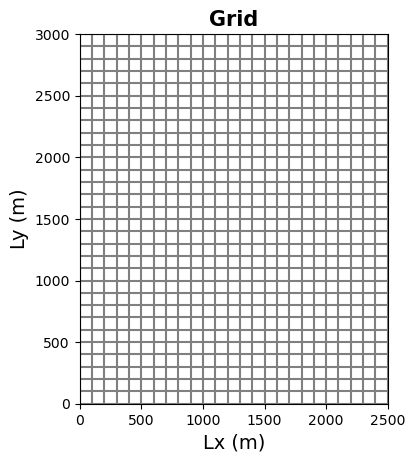

In [38]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

## 4. Setup constant head boundaries, active cells and initial heads (BAS Package)


#### 4.1 Define cell activity: IBOUND 

In [39]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active     

#set constant head boundary on the left
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

#print("ibound values: \n", ibound)

#### 4.2 Define starting heads 

In [40]:
# --- choose arbitrary flat datum (only differences matter) ---
z_surf = 100.0

# --- corner WTDs (depth below surface) ---
WTD_NW, WTD_SW = 4.8, 5.4
WTD_NE, WTD_SE = 50.2, 51.6

# --- convert to head elevations ---
h_NW = z_surf - WTD_NW
h_SW = z_surf - WTD_SW
h_NE = z_surf - WTD_NE
h_SE = z_surf - WTD_SE

# --- interpolate boundary heads by row (south -> north) ---
# fraction from south (0) to north (1) at row centers
f = (np.arange(nrow) + 0.5) / nrow

h_west = h_SW + f * (h_NW - h_SW)   # left boundary (west)
h_east = h_SE + f * (h_NE - h_SE)   # right boundary (east)

# --- initialize heads everywhere as a west→east linear plane (row by row) ---
H_init = np.zeros((nlay, nrow, ncol), dtype=np.float32)

for i in range(nrow):
    H_init[0, i, :] = np.linspace(h_west[i], h_east[i], ncol).astype(np.float32)

# (optional) enforce boundaries explicitly (not strictly necessary now, but harmless)
H_init[0, :, 0]  = h_west
H_init[0, :, -1] = h_east

#print("West boundary heads (south → north):")
#print(h_west)

#print("\nEast boundary heads (south → north):")
#print(h_east)


#### 4.3 Create BAS object

In [41]:
#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#### 4.4 Plot the grid and ibound

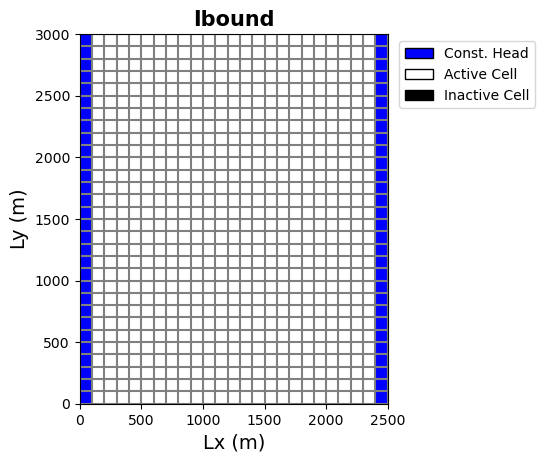

In [42]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

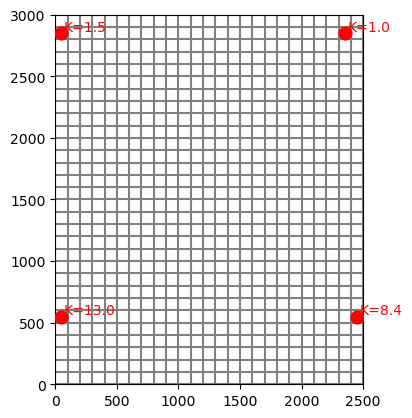

In [43]:
# Map observation wells (K-control points) 

# MODFLOW (row, col, K)
k_points_rc = [
    (1,  0,  1.5),
    (24, 0, 13.0),
    (1,  23, 1.0),
    (24, 24, 8.4)
]

x_pts = []
y_pts = []
labels = []

for r, c, k in k_points_rc:
    x = (c + 0.5) * dx
    y = (nrow - r - 0.5) * dy   # <<< THIS is the fix
    x_pts.append(x)
    y_pts.append(y)
    labels.append(f"K={k}")

plt.scatter(x_pts, y_pts, color='red', s=80, zorder=5)

for x, y, lab in zip(x_pts, y_pts, labels):
    plt.text(x + dx*0.2, y + dy*0.2, lab, color='red')

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
modelmap.plot_grid()
plt.scatter(x_pts, y_pts, color='red', s=80, zorder=5)

plt.xlim(0, ncol*dx)
plt.ylim(0, nrow*dy)
plt.show()



In [44]:
#Define your K-control points in model coordinates

# MODFLOW-style indices (row, col, K)
k_points_rc = [
    (1,  0,  1.5),   # NW
    (25, 0, 13.0),   # SW
    (1,  24, 1.0),   # NE
    (25, 24, 8.4)    # SE
]

# Convert (row, col) -> (x, y) in meters at cell centers
k_points_xy = []
for r, c, k in k_points_rc:
    x = (c + 0.5) * dx
    y = (nrow - r - 0.5) * dy   # IMPORTANT: flip row for map coordinates
    k_points_xy.append((x, y, k))

print("K control points (x, y, K):")
for p in k_points_xy:
    print(p)


K control points (x, y, K):
(50.0, 2850.0, 1.5)
(50.0, 450.0, 13.0)
(2450.0, 2850.0, 1.0)
(2450.0, 450.0, 8.4)


In [45]:
#Build the grid of cell-center coordinates for the whole model

Lx = ncol * dx
Ly = nrow * dy

x_centers = (np.arange(ncol) + 0.5) * dx
y_centers = (np.arange(nrow) + 0.5) * dy
Xc, Yc = np.meshgrid(x_centers, y_centers)   # shapes (nrow, ncol)


In [46]:
#Inverse distance weight (power=2)

def idw_2d(X, Y, points, power=2.0, eps=1e-12):
    """
    IDW interpolation on a 2D grid.
    X, Y: 2D arrays of coordinates (nrow, ncol)
    points: list of (x, y, value)
    power: IDW power parameter (p). p=2 is common.
    """
    num = np.zeros_like(X, dtype=float)
    den = np.zeros_like(X, dtype=float)

    for (x, y, v) in points:
        d2 = (X - x)**2 + (Y - y)**2
        w = 1.0 / ((d2 + eps) ** (power / 2.0))
        num += w * v
        den += w

    return num / den


In [47]:
#Compute IDW K field

hk2d = idw_2d(Xc, Yc, k_points_xy, power=2.0)
print("IDW hk2d min/max:", hk2d.min(), hk2d.max())

IDW hk2d min/max: 1.0 13.0


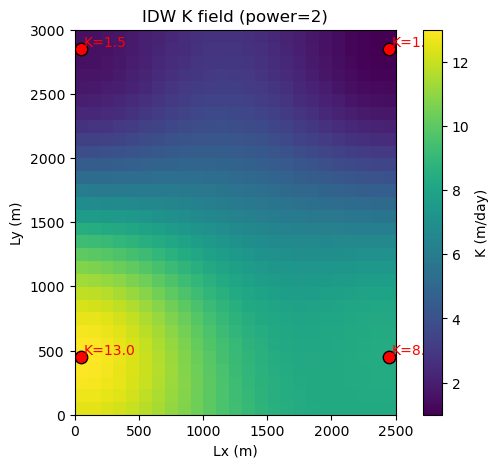

In [48]:
#Plot IDW field

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.imshow(hk2d, origin="lower", extent=[0, Lx, 0, Ly])
plt.colorbar(label="K (m/day)")
plt.title("IDW K field (power=2)")

# overlay points
x_pts = [p[0] for p in k_points_xy]
y_pts = [p[1] for p in k_points_xy]
plt.scatter(x_pts, y_pts, c="red", s=80, edgecolors="black")

for (x, y, k) in k_points_xy:
    plt.text(x + 0.2*dx, y + 0.2*dy, f"K={k}", color="red")

plt.xlim(0, Lx)
plt.ylim(0, Ly)
plt.xlabel("Lx (m)")
plt.ylabel("Ly (m)")
plt.show()


## 5. Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

#### 5.1 Set layer properties

In [49]:
# scalar defaults (won't control spatial K if you use hk array)
K_horiz = 1.0
K_vert  = 1.0

n = 0.35
Ss = 0.001
Sy = 0.3
uncnf = 1

# IDW K field is hk2d (nrow, ncol)
hk = hk2d[np.newaxis, :, :]     # (nlay, nrow, ncol)

anis_v = 10.0                   # optional
vka = hk / anis_v               # or vka = hk


#### 5.2 Make LPF object

In [50]:
#Feed values into model's K field

hk = hk2d[np.newaxis, :, :]   # shape (1, nrow, ncol)


lpf = flopy.modflow.ModflowLpf(
    m,
    laytyp=1,      # convertible (unconfined)
    hk=hk,
    vka=vka,
    ipakcb=53,
    laywet=1,
    wetfct=0.1,
    iwetit=10,
    ihdwet=1,
    wetdry=0.5
)


## 6. Recharge

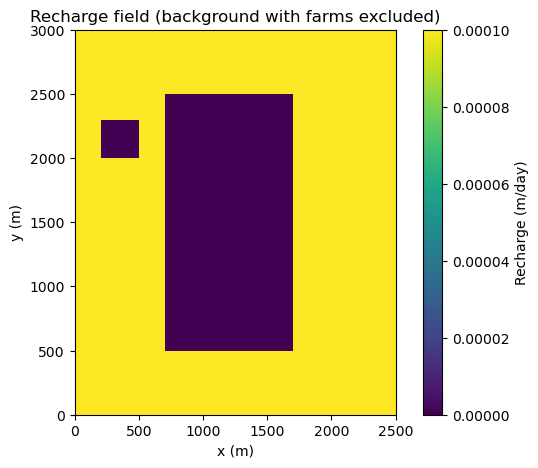

In [51]:
rch_bg = 1e-4   # m/day

rech_zone = np.ones((nrow, ncol), dtype=float) * rch_bg

x_centers = (np.arange(ncol) + 0.5) * dx
y_centers = (np.arange(nrow) + 0.5) * dy
Xc, Yc = np.meshgrid(x_centers, y_centers)

# NO-recharge masks (purple)
mask1 = (            # acme farm (large rectangle)
    (Xc > 700) & (Xc < 1700) &
    (Yc > 500) & (Yc < 2500)
)

mask2 = (            # wildcat farm (small rectangle, top-left-ish)
    (Xc > 200) & (Xc < 500) &
    (Yc > 2000) & (Yc < 2300)
)

no_rch = mask1 | mask2
rech_zone[no_rch] = 0.0

Lx = ncol * dx
Ly = nrow * dy

plt.figure(figsize=(7,5))
plt.imshow(rech_zone, origin="lower", extent=[0, Lx, 0, Ly])
plt.colorbar(label="Recharge (m/day)")
plt.title("Recharge field (background with farms excluded)")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()


In [52]:
rch = flopy.modflow.ModflowRch(
    m,
    nrchop=1,
    rech=rech_zone,
    ipakcb=53
)


## 7. Wells

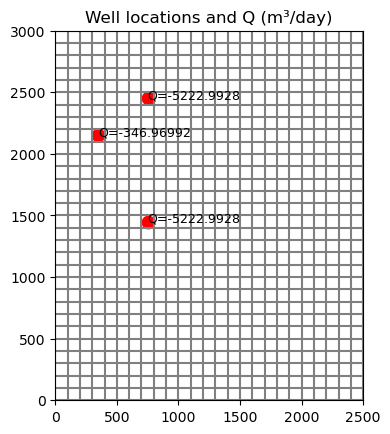

In [53]:
# Define & plot wells

CWU_alf = 74.3      # in/yr
CWU_cot = 41.2      # in/yr
Area_alf = 2.02E6     # m2
Area_cot = 1.21E5     # m2
ConvFact = 6.96E-5

Q1 = - ( .5 * Area_alf * CWU_alf * ConvFact)     # Alfalfa1 in m3/day
Q2 = - ( .5 * Area_alf * CWU_alf * ConvFact)     # Alfalfa2 in m3/day
Q3 = - (Area_cot * CWU_cot * ConvFact)     # Cotton in m3/day

#Q1 = 0
#Q2 = 0
#Q3 = 0

well1 = [0, 5, 7, Q1]
well2 = [0, 15, 7, Q2]
well3 = [0, 8, 3, Q3]

wel_spd = {0: [well1, well2, well3]}              #create a dictionary with entries for each stress period

modelmap = flopy.plot.PlotMapView(model=m, layer=0)
modelmap.plot_grid()

for (lay, r, c, q) in wel_spd[0]:
    x = (c + 0.5) * dx
    y = (nrow - r - 0.5) * dy
    plt.scatter(x, y, s=80, color="red")
    plt.text(x, y, f"Q={q}", fontsize=9)

plt.title("Well locations and Q (m³/day)")

plt.show()


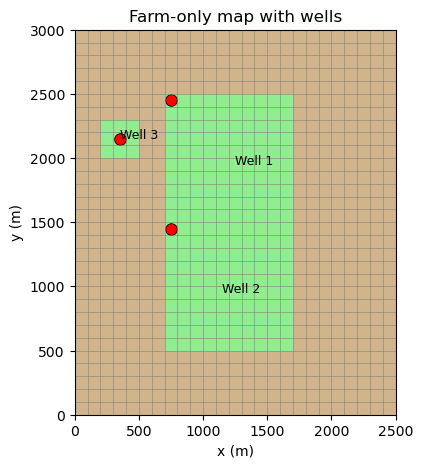

In [54]:
# Create domain grid showing farms & wells

from matplotlib.colors import ListedColormap

# --- farm mask (ONLY farms, not bottom excluded band) ---
farm_mask = mask1 | mask2   # ACME + Wildcat only

# categorical grid: 0 = background, 1 = farm
farm_grid = np.zeros((nrow, ncol), dtype=int)
farm_grid[farm_mask] = 1

# colors
cmap = ListedColormap(["tan", "lightgreen"])

fig, ax = plt.subplots(figsize=(7, 5))

# use PlotMapView for grid overlay
pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

# plot farm map
ax.imshow(
    farm_grid,
    origin="lower",
    extent=[0, Lx, 0, Ly],
    cmap=cmap,
    interpolation="nearest"
)

# draw grid
pmv.plot_grid(linewidth=0.4)

# --- WELL LOCATIONS (row, col → x, y) ---
wells = [well1, well2, well3]

for k, i, j, q in wells:
    x = (j + 0.5) * dx
    y = (nrow - i - 0.5) * dy
    ax.scatter(
        x, y,
        c="red", s=70, marker="o",
        edgecolors="k", linewidths=0.6
    )

# labels
ax.text((12 + 0.5) * dx, (nrow - 10 - 0.5) * dy, "Well 1", fontsize=9)
ax.text((11 + 0.5) * dx, (nrow - 20 - 0.5) * dy, "Well 2", fontsize=9)
ax.text((3 + 0.5) * dx,  (nrow - 8  - 0.5) * dy, "Well 3", fontsize=9)

# labels and title
ax.set_title("Farm-only map with wells")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)

plt.show()


In [55]:
wel = flopy.modflow.ModflowWel(
    m,
    stress_period_data=wel_spd,
    ipakcb=53   # writes well flows to CBC (nice for budgets)
)

## 8. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### Setup outputs

In [56]:
#create oc stress period data. 
#(0,0) tells OC package to save data for stress period 1, time step 1.
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


#### Make OC object 

In [57]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 9. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### Make the PCG object

In [58]:
pcg = flopy.modflow.ModflowPcg(model=m)

pcg = flopy.modflow.ModflowPcg(
    m,
    mxiter=500,     # outer iterations
    iter1=200,      # inner iterations
    hclose=1e-3,    # head tolerance
    rclose=1e-1,    # residual tolerance (start looser)
    relax=0.97,     # damping for nonlinear unconfined
    npcond=1        # preconditioning
)


/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:623: UserWarning: Unit 27 of package PCG already in use.
  warn(
/opt/conda/envs/hwrs564b/lib/python3.11/site-packages/flopy/mbase.py:632: UserWarning: Two packages of the same type, Replacing existing 'PCG' package.
  warn(


## 10. Write inputs and run the model 

#### Write Inputs

In [59]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### Run the model

In [60]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: WildcatFarmS1_flopy.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12  4:04:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/12  4:04:49
 Elapsed run time:  0.007 Seconds

  Normal termination of simulation


## 11. Plot the results  

#### Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile

##### Read the heads 

In [61]:
headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = headobj.get_times()                #returns a list of timesteps
head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

#print('timesteps:', times)         
#print('final head:', 'dimensions', np.shape(head), '\n', head)    
#print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
#print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)

##### Write Heads as csv

In [62]:
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])


##### Use cell-by-cell flow output to analyze flux distribution along model boundaries


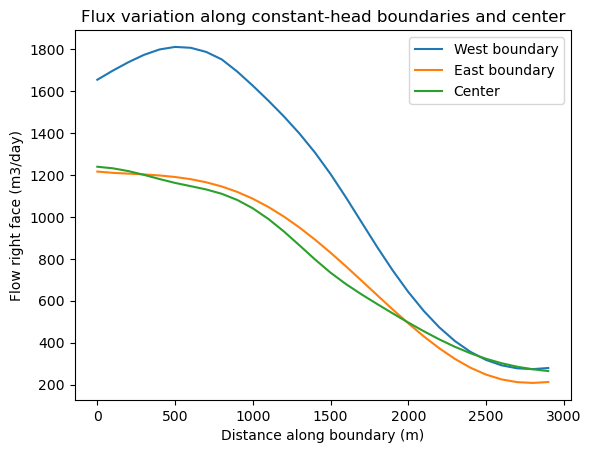

In [63]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
times = budgobj.get_times()
frf = budgobj.get_data(text='FLOW RIGHT FACE', totim=times[-1])  #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='FLOW FRONT FACE',  totim=times[-1])   #returns an array of flow rates for front face of cells
                            # (optional, if you ever need it)

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
centerflux = flux_vals[:, ncol//2]

y = np.arange(0, nrow*dy, dy)

plt.figure()
plt.plot(y, leftflux, label="West boundary")
plt.plot(y, rightflux, label="East boundary")
plt.plot(y, centerflux, label="Center")
plt.xlabel("Distance along boundary (m)")
plt.ylabel("Flow right face (m3/day)")
plt.legend()
plt.title("Flux variation along constant-head boundaries and center")
plt.show()



#### Prepare K array & calculate: Kmean, flux on west boundary, Keff

In [64]:
# --- Prepare K array (ensure 2D) ---
K_vals = np.array(hk)
if K_vals.ndim == 3:
    K_vals = K_vals[0]   # use layer 0

# --- Mean hydraulic conductivities ---
k_arr = np.mean(K_vals)
k_harm = hmean(K_vals.flatten())

# --- Total flux across west boundary (m3/day) ---
flux_tot = np.sum(flux_vals[:, 0])

# --- Effective K from Darcy's law ---
thk = top - botm
area = nrow * dy * thk
dh_dl = np.mean((H_init[0, :, 0] - H_init[0, :, -1]) / Lx)

k_eff = flux_tot / area / dh_dl

print(
    "ArrMean", np.round(k_arr, 2),
    "Hmean", np.round(k_harm, 2),
    "Keff", np.round(k_eff, 2),
    "Q", np.round(flux_tot, 2)
)


ArrMean 6.37 Hmean 4.32 Keff 6.11 Q 33594.44


#### Evaluate the head gradients

Head Gradient 0.01832533 m/m


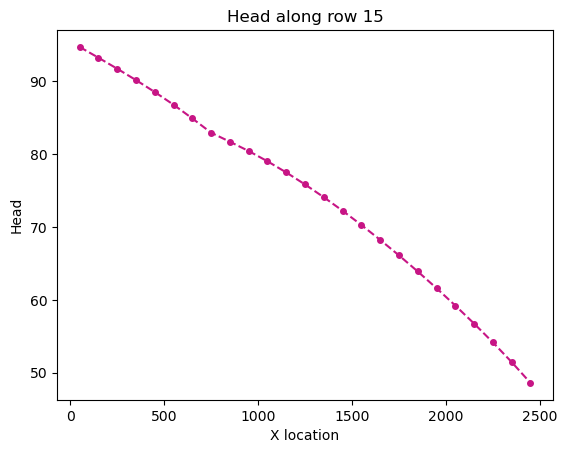

In [65]:
head_fig = plt.figure() 
#x=np.arange(100,2600,100) 
x=np.arange(dx/2,Lx,dx)
y=head[0,4,:]
plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
plt.xlabel('X location')
plt.ylabel('Head')
plt.title("Head along row 15")
#plt.axvline(x=1200)

#Save figure
# plt.savefig('Head_Transect.png') #save figure as a png

hgrad=(head[0,14,0]-head[0,14,-1])/Lx
print("Head Gradient", hgrad, "m/m") 

#### 3D plot of heads

Text(0.5, 0.92, 'Steady-State Model Head Profile')

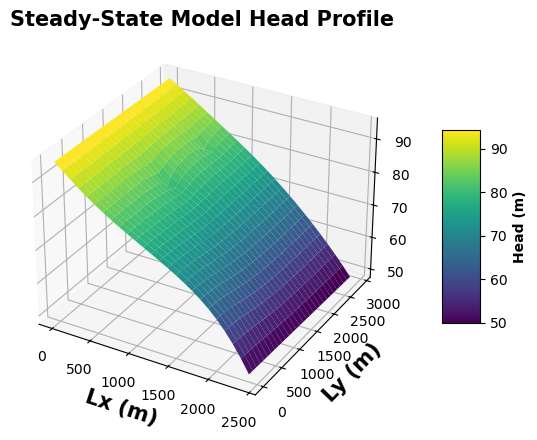

In [66]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
#ax = fig_3d.gca(projection='3d')
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

### Contour Head plot

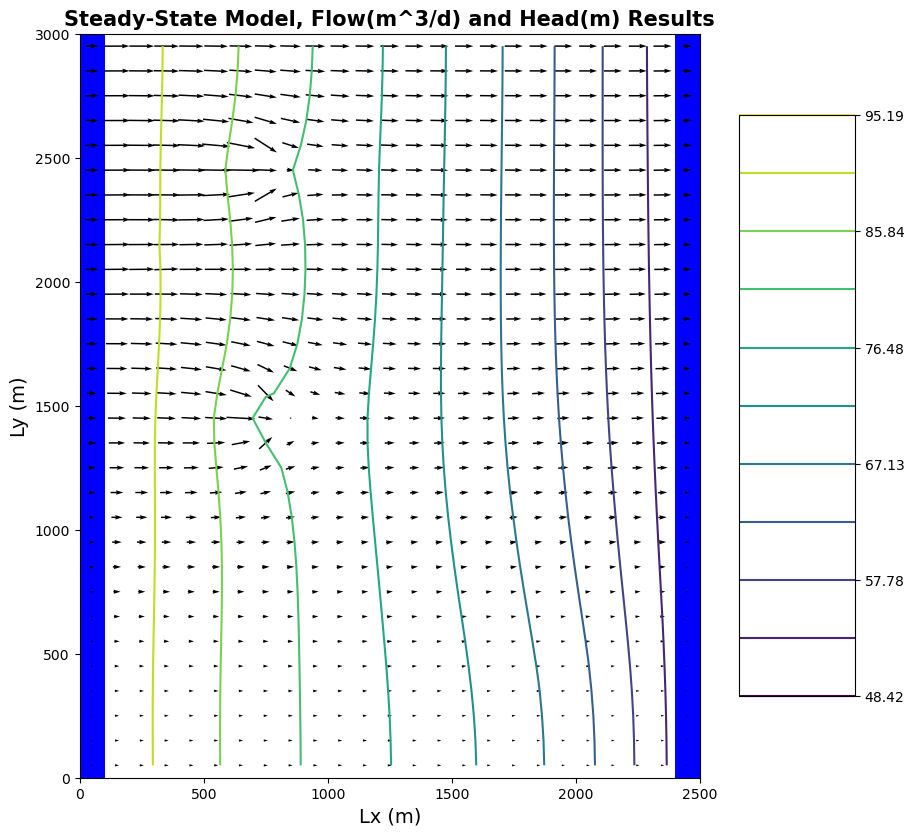

In [67]:
#Calculate the volumetric dischard (m3/day)
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf[0], fff[0], None), m) 

#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
quiver = modelmap.plot_vector(qx, qy)
#flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)

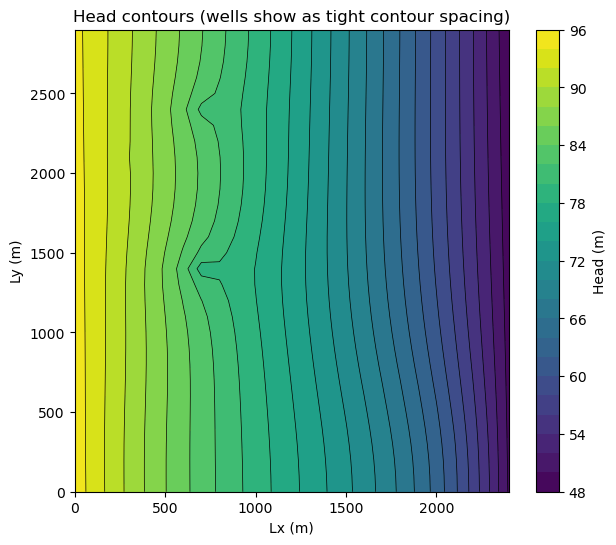

In [68]:
plt.figure(figsize=(7,6))
plt.contourf(X, Y, Z, levels=30, cmap="viridis")
plt.colorbar(label="Head (m)")
plt.contour(X, Y, Z, levels=30, colors="k", linewidths=0.5)
plt.title("Head contours (wells show as tight contour spacing)")
plt.xlabel("Lx (m)")
plt.ylabel("Ly (m)")
plt.show()


## Calculate Drawdown at Wildcat Farm

In [70]:
# Load baseline no well heads

baseline_path = Path("/workspaces/hwrs564b_course_materials_tracy/mywork/baseline_no_wells_heads.npy")
H0 = np.load(baseline_path)

print("Baseline loaded.")
print("Shape:", H0.shape)
print("Baseline min/max:", np.nanmin(H0), np.nanmax(H0))

Baseline loaded.
Shape: (30, 25)
Baseline min/max: 48.42333 95.19


Reading scenario heads: /workspaces/hwrs564b_course_materials_tracy/mywork/WildcatFarmS1_flopy.hds
H1 (scenario) min/max: 48.42333 95.19
Drawdown min/max: 0.0 6.7648697


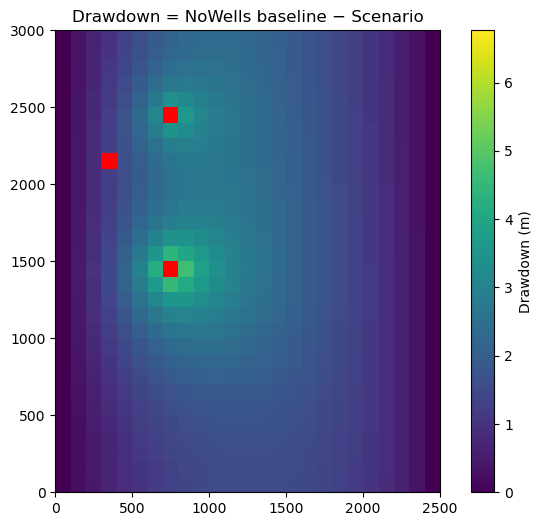

In [71]:
hds_path = Path(m.model_ws) / f"{m.name}.hds"
print("Reading scenario heads:", hds_path)

headobj = flopy.utils.HeadFile(str(hds_path))
H1 = headobj.get_data(totim=headobj.get_times()[-1])[0]
print("H1 (scenario) min/max:", np.nanmin(H1), np.nanmax(H1))

assert H0.shape == H1.shape, f"Grid mismatch: H0 {H0.shape} vs H1 {H1.shape}"

drawdown = H0 - H1
print("Drawdown min/max:", np.nanmin(drawdown), np.nanmax(drawdown))

fig, ax = plt.subplots(figsize=(8,6))
pmv = flopy.plot.PlotMapView(model=m, layer=0, ax=ax)

im = pmv.plot_array(drawdown)
plt.colorbar(im, ax=ax, label="Drawdown (m)")

pmv.plot_bc("WEL")  # show well cells if present
ax.set_title("Drawdown = NoWells baseline − Scenario")
ax.set_aspect("equal")
plt.show()